In [296]:
import jaxoplanet
import jax.numpy as np
from jax import vmap, jit
import jax.random as jr 

import matplotlib.pyplot as plt
import chainconsumer

from jaxoplanet.units import unit_registry as ureg
import jpu.numpy as jnpu
import astropy.units as u 
from astropy.time import Time

import pandas as pd

In [364]:
P, dP = 11.78*ureg.year, 0.10*ureg.year # period, years
a, da = 0.0314, 0.0010 # semi-major axis, arcsec

parallax, dparallax = 0.0664*ureg.arcsec, 0.0003*ureg.arcsec # parallax

e, de = 0.59*ureg.dimensionless, 0.05*ureg.dimensionless # eccentricity
i, di = 65*ureg.deg, 1*ureg.deg
omega, domega = 114*ureg.deg, 5*ureg.deg
Omega, dOmega = 132*ureg.deg, 2*ureg.deg


ma, dma = 0.89*ureg.M_sun, 0.08*ureg.M_sun # mass of primary, solar masses
mb, dmb = 0.09*ureg.M_sun, 0.008*ureg.M_sun # mass of secondary, solar masses
mcma, dmcma = 0.101*ureg.dimensionless, 0.003*ureg.dimensionless # mass ratio

T_0, dT_0 = 1991.9*ureg.year, 0.2*ureg.year # years
date_jwst = Time(59735.57,format='mjd').decimalyear*ureg.year # MJD

In [365]:
# docstrings for jaxoplanet.Orbit

# central (Optional[Central]): The Central object that this Body orbits
#     [Central].
# time_transit (Optional[Quantity]): The epoch of a reference transit
#     [time unit].
# time_peri (Optional[Quantity]): The epoch of a reference periastron passage
#     [time unit].
# period (Optional[Quantity]): Orbital period [time unit].
# semimajor (Optional[Quantity]): Semi-major axis in [length unit].
# inclination (Optional[Quantity]): Inclination of orbital plane in
#     [angular unit].
# impact_param (Optional): Impact parameter.
# eccentricity (Optional): Eccentricity, must be ``0 <= eccentricity < 1``
#     where 0 = circular orbit.
# omega_peri (Optional[Quantity]): Argument of periastron [angular unit].
# sin_omega_peri (Optional): sin(argument of periastron).
# cos_omega_peri (Optional): cos(argument of periastron).
# asc_node (Optional[Quantity]): Longitude of ascending node [angular unit].
# sin_asc_node (Optional): sin(longitude of ascending node).
# cos_asc_node (Optional): cos(longitude of ascending node).
# mass (Optional[Quantity]): Mass of orbiting body [mass unit].
# radius (Optional[Quantity]): Radius of orbiting body [length unit].
# central_radius (Optional[Quantity]): Radius of central body [length unit].
# radial_velocity_semiamplitude (Optional[Quantity]): The radial velocity
#     semi-amplitude [length/time unit].
# parallax (Optional[Quantity]): Parallax (to convert position/velocity into
#     arcsec). [length unit].

In [366]:
from jaxoplanet.orbits.keplerian import System, Central, Body
central = Central(mass=ma,radius=1.0)
system = System(central).add_body(mass=mb, radius=1.0, period=P, inclination=i,
                                  eccentricity=e, omega_peri=omega,
                                  asc_node=Omega, time_peri=T_0,parallax=parallax)

In [367]:
t = date_jwst
# t = jnpu.linspace(0,P,100)
dx, dy, dz = system.relative_position(t)

rho = jnpu.sqrt(dx**2 + dy**2).to('milliarcsec')
theta = jnpu.arctan2(dx,dy).to('deg')

print(rho,theta)

[353.16827] milliarcsecond [169.41837] degree


In [368]:
def get_astrometry(params):
    mcma, mb, P, i, e, omega, Omega, T_0, parallax = params
    # add units
    P = P*ureg.year
    i = i*ureg.deg
    e = e*ureg.dimensionless
    omega = omega*ureg.deg
    Omega = Omega*ureg.deg
    T_0 = T_0*ureg.year
    parallax = parallax*ureg.arcsec
    ma = mb/mcma
    
    central = Central(mass=ma,radius=1.0)
    system = System(central).add_body(mass=mb, radius=1.0, period=P, inclination=i,
                                    eccentricity=e, omega_peri=omega,
                                    asc_node=Omega, time_peri=T_0,parallax=parallax)    

    dx, dy, dz = system.relative_position(date_jwst)

    rho = jnpu.sqrt(dx**2 + dy**2).to('milliarcsec')
    theta = jnpu.arctan2(dx,dy).to('deg')

    return rho, theta

In [369]:
params = [mcma, mb, P, i, e, omega, Omega, T_0, parallax]
dparams = [dmcma, dmb, dP, di, de, domega, dOmega, dT_0, dparallax]

params = np.array([p.magnitude for p in params])
dparams = np.array([p.magnitude for p in dparams])


In [371]:
rho, theta = get_astrometry(params)
print(rho,theta)

[353.2991] milliarcsecond [169.41838] degree


In [372]:
f = jit(vmap(get_astrometry))

key = jr.PRNGKey(0)

mcparams = jr.normal(key, (10000,9), dtype=np.float32) * dparams + params

In [373]:
rhos, thetas = f(mcparams)

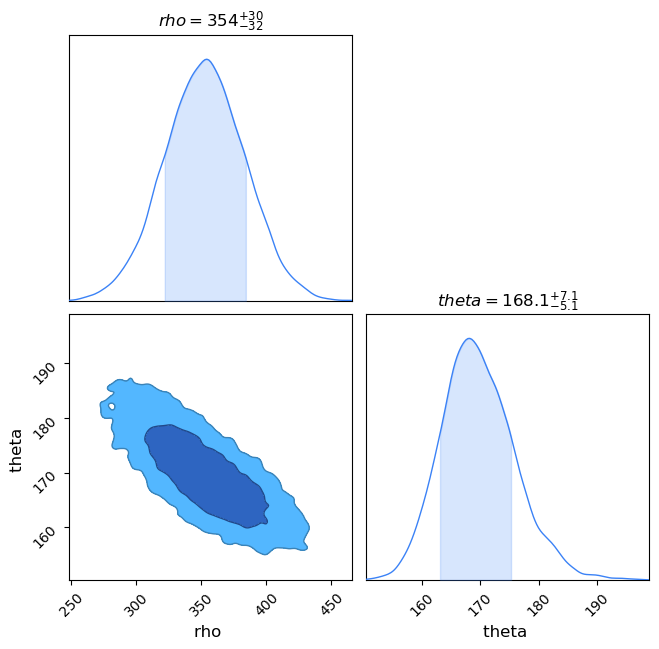

In [374]:
c = chainconsumer.ChainConsumer()
df = pd.DataFrame({'rho':rhos.magnitude.squeeze(), 'theta':((thetas.magnitude.squeeze() - 90) % 180) + 90})
chain = chainconsumer.Chain(samples=df,name='Chain')
c.add_chain(chain)
fig = c.plotter.plot()


In [361]:
df.to_csv('astrometry.csv',index=False)